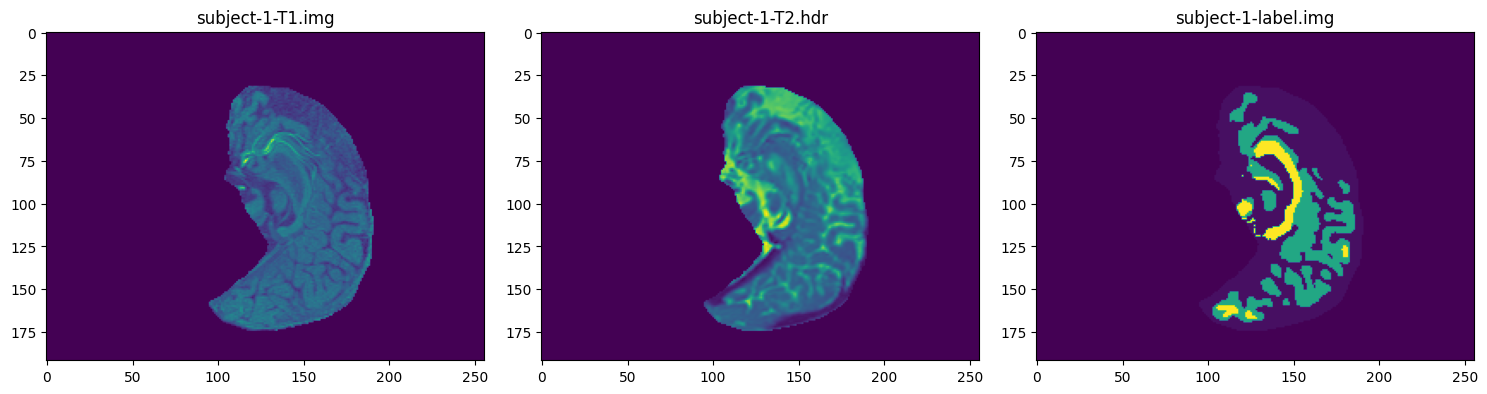

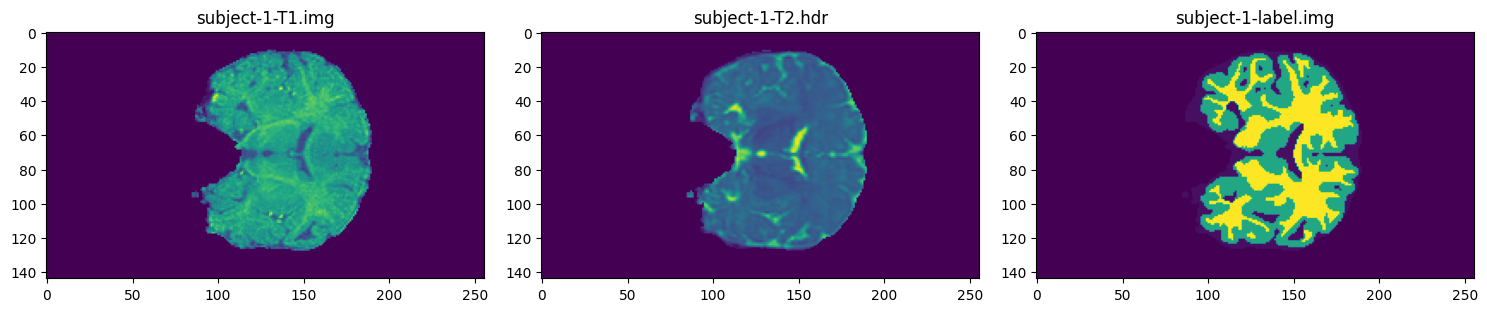

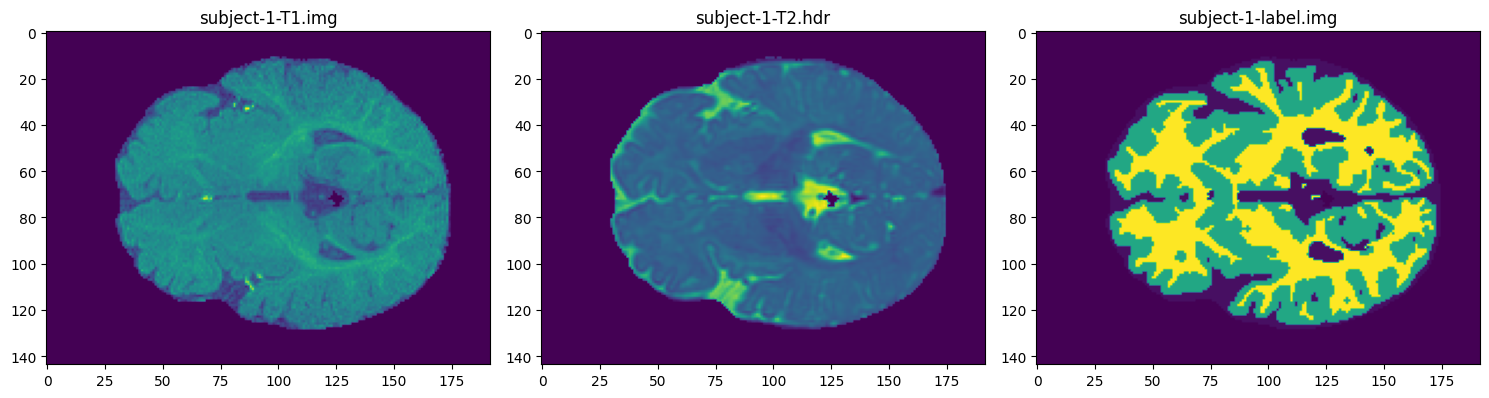

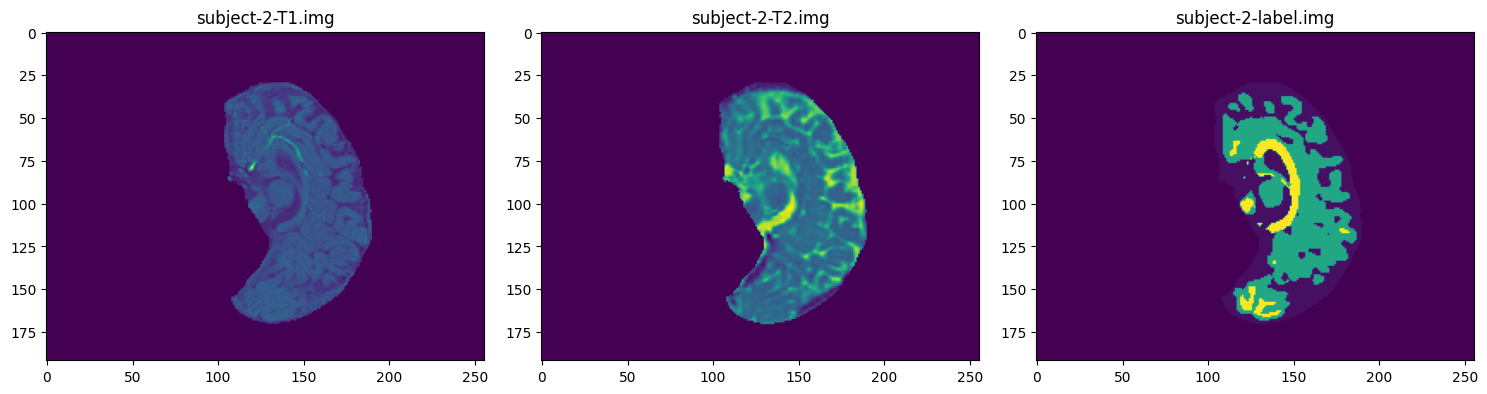

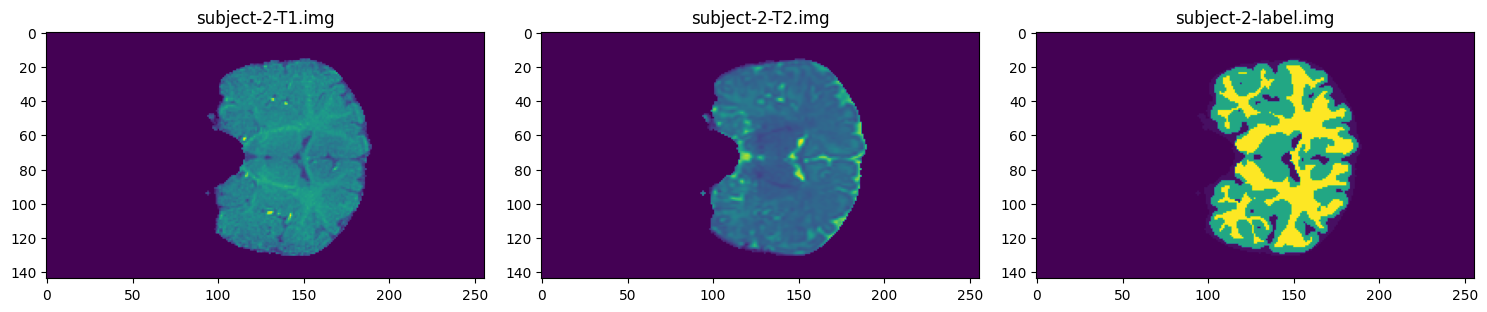

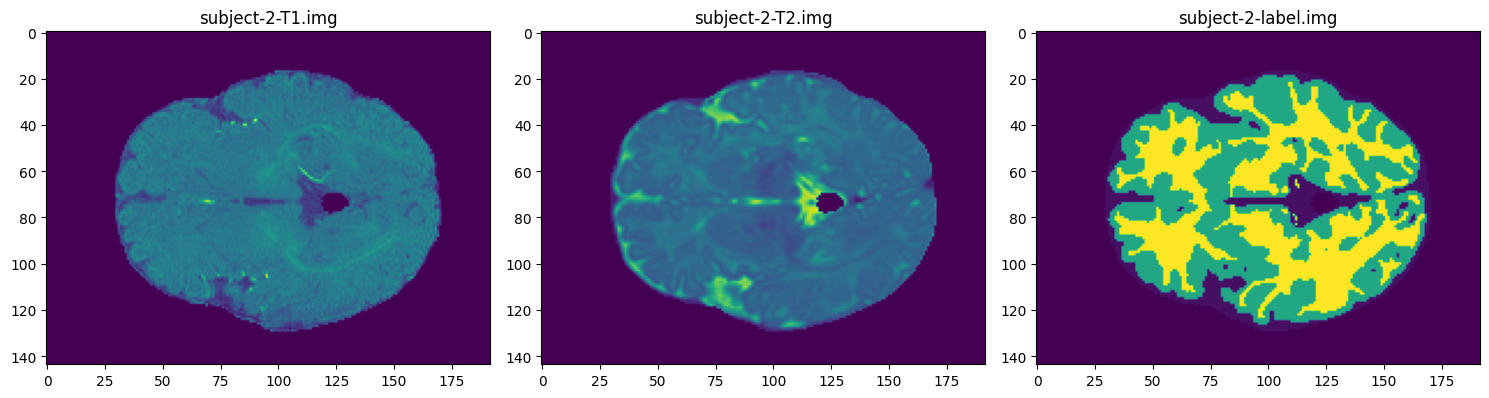

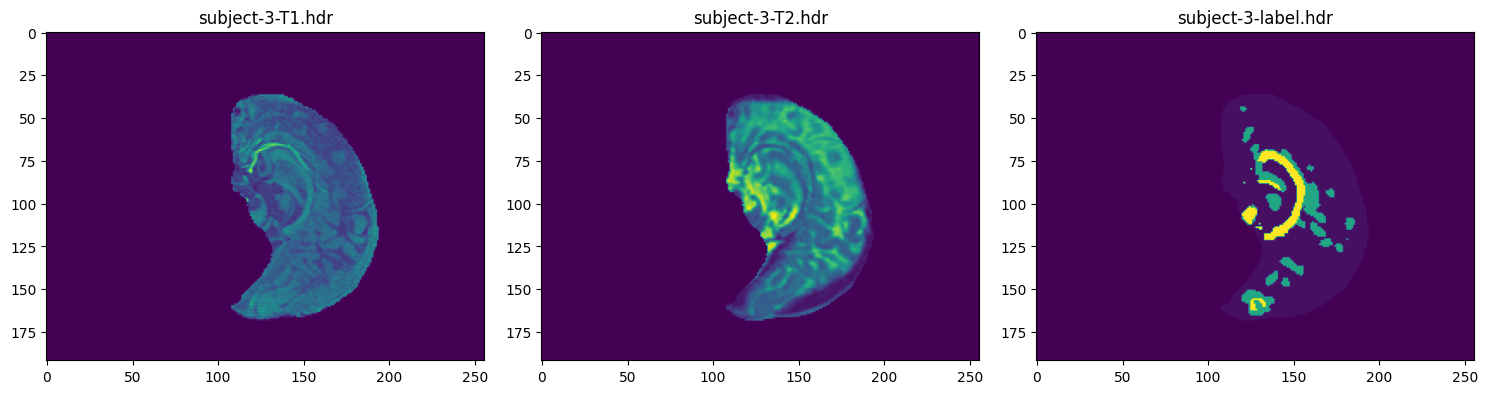

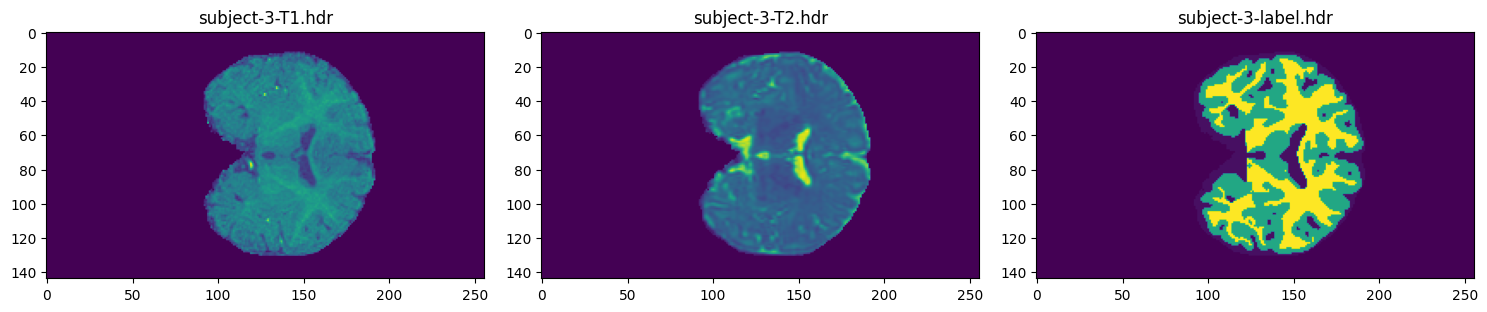

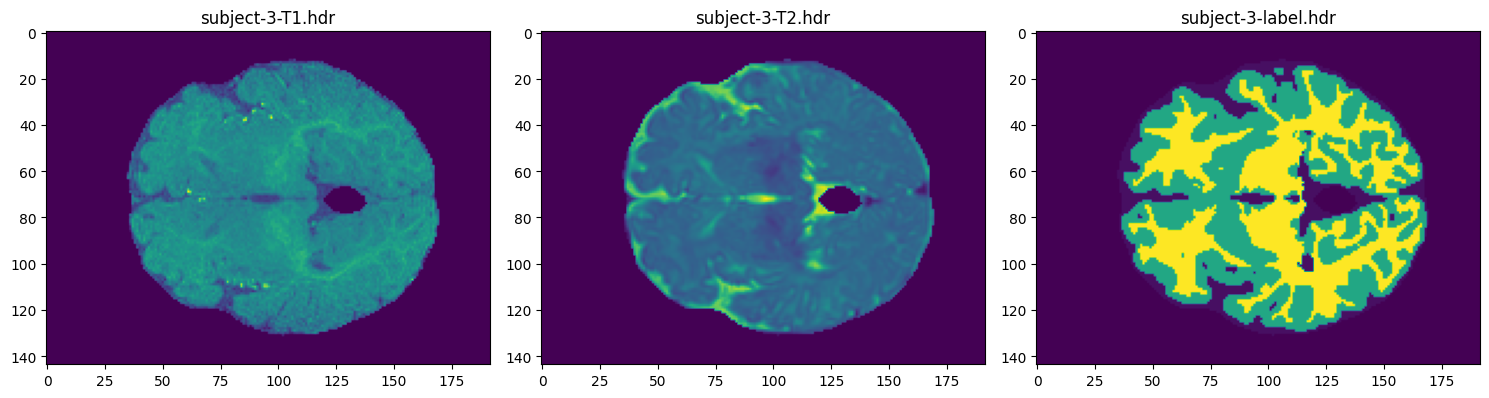

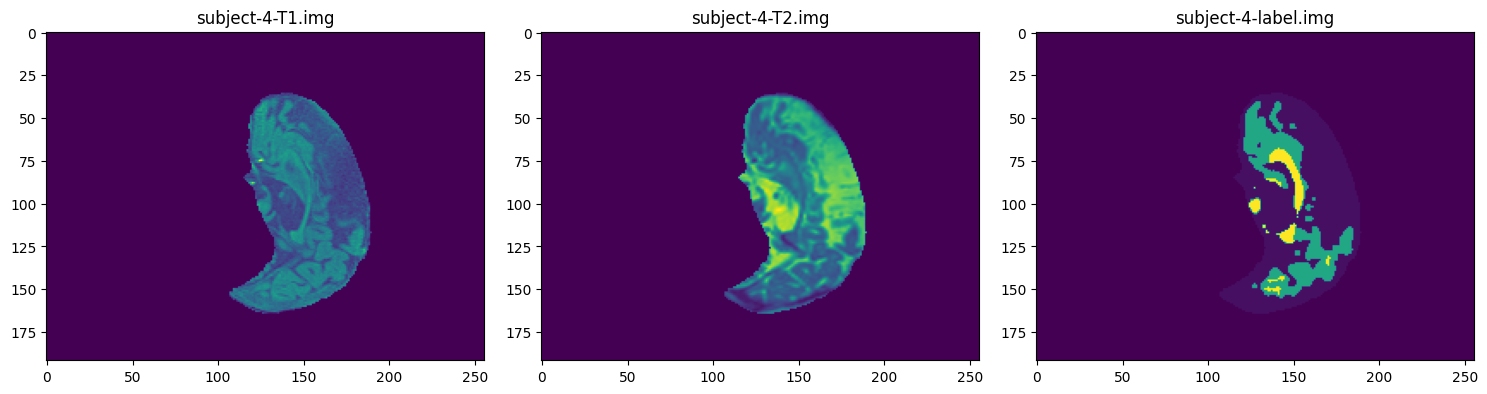

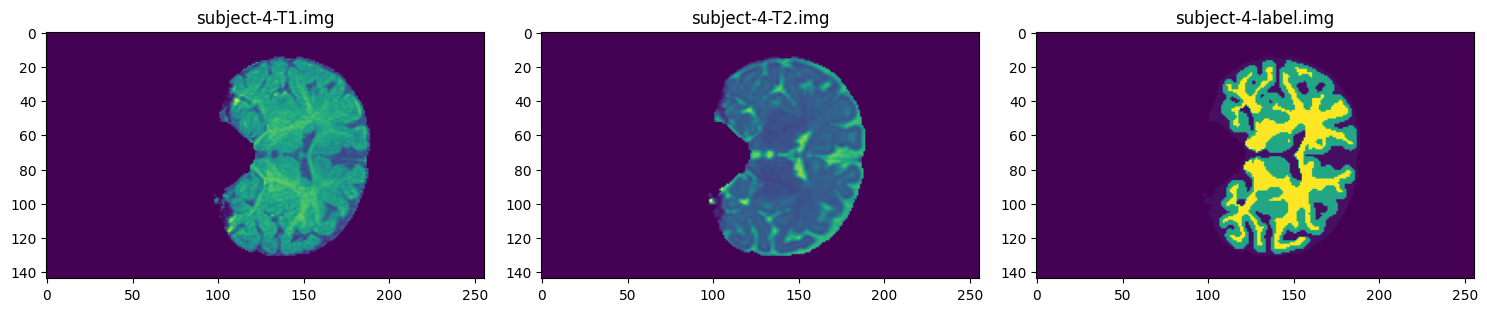

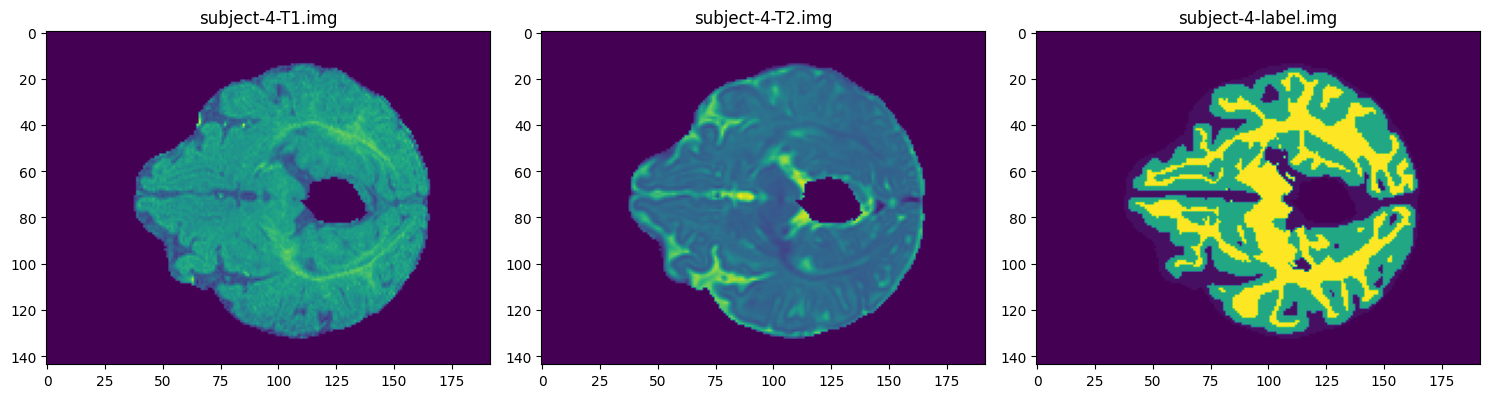

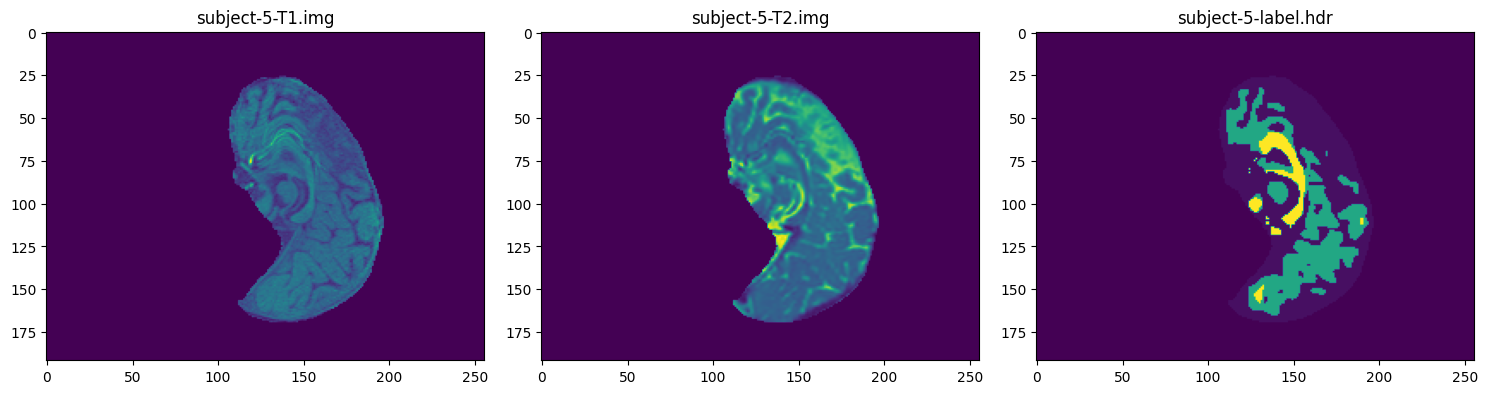

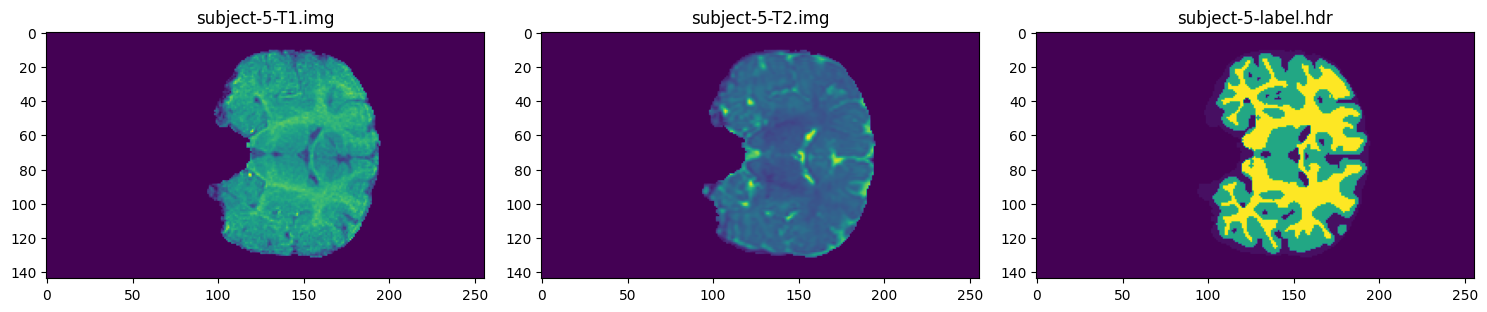

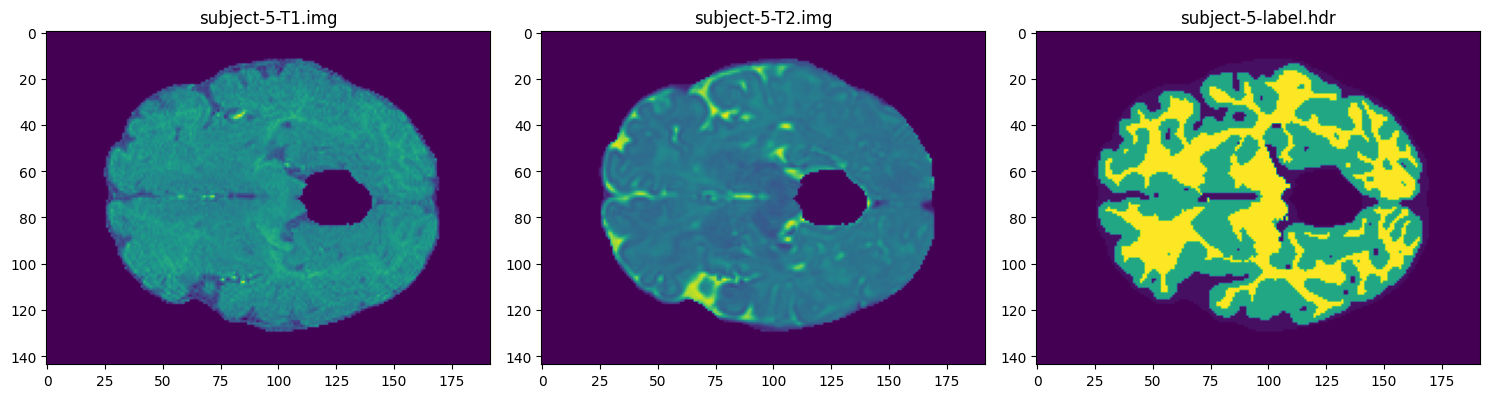

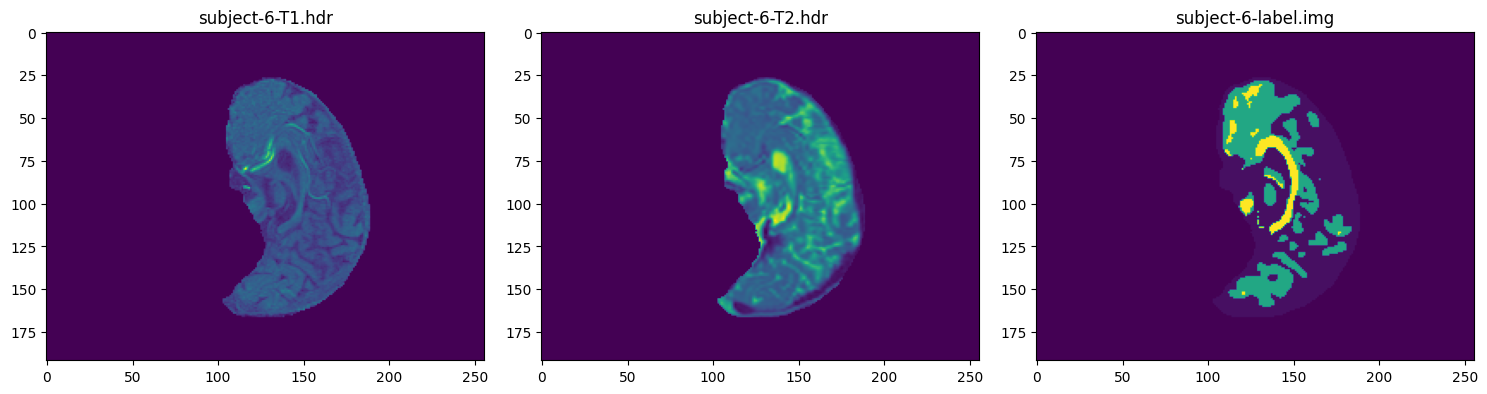

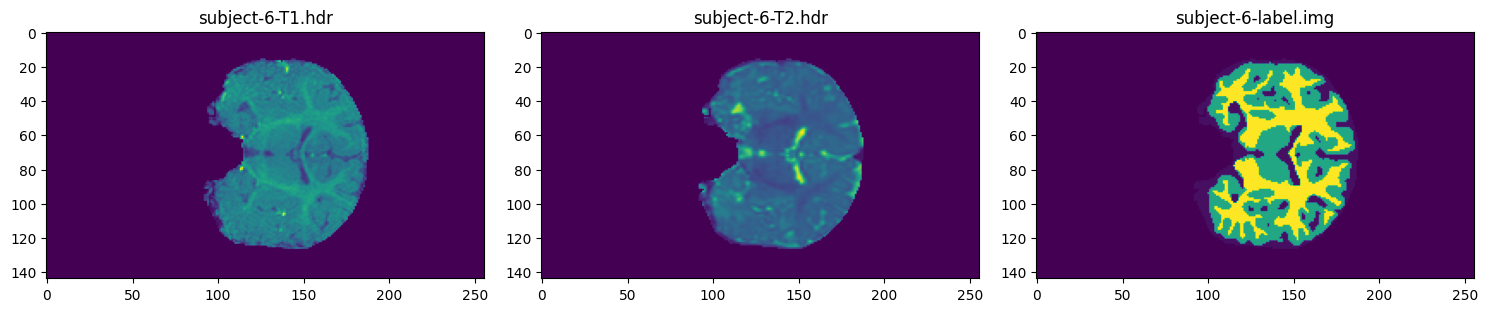

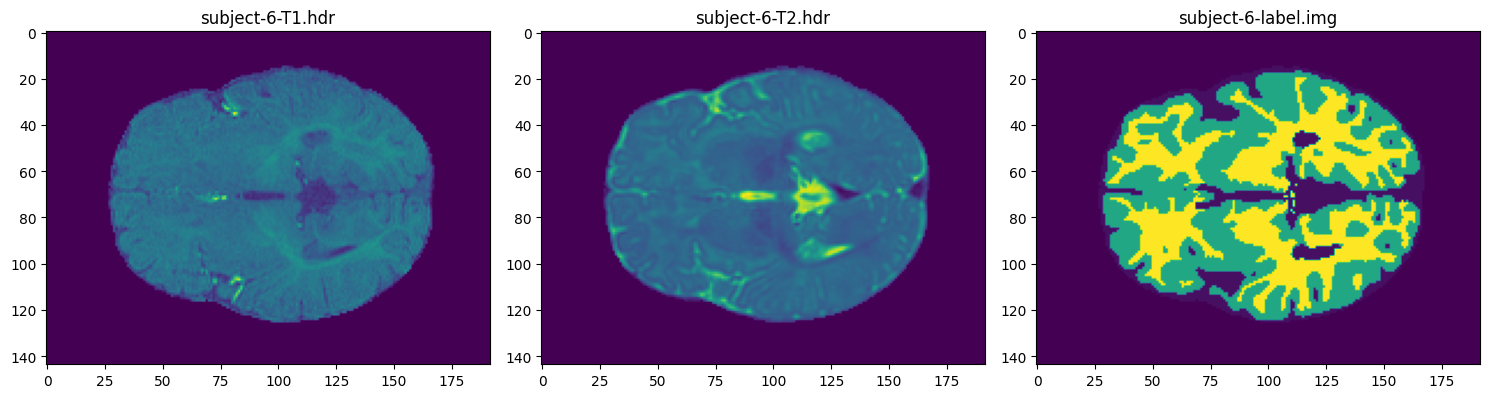

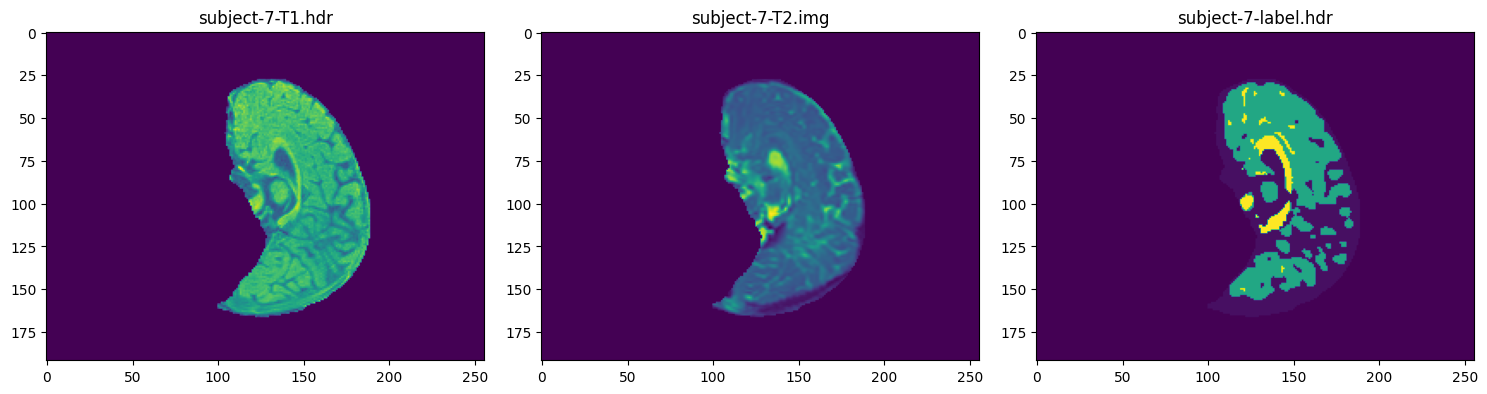

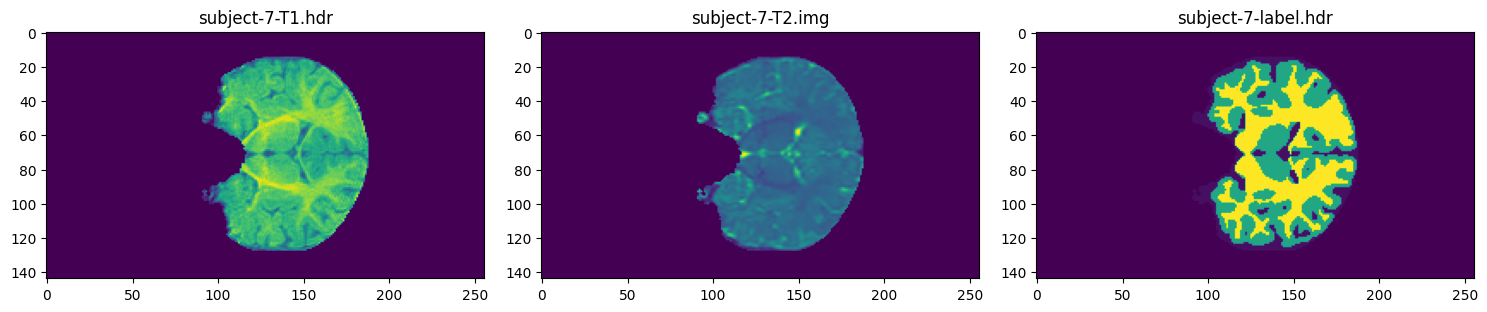

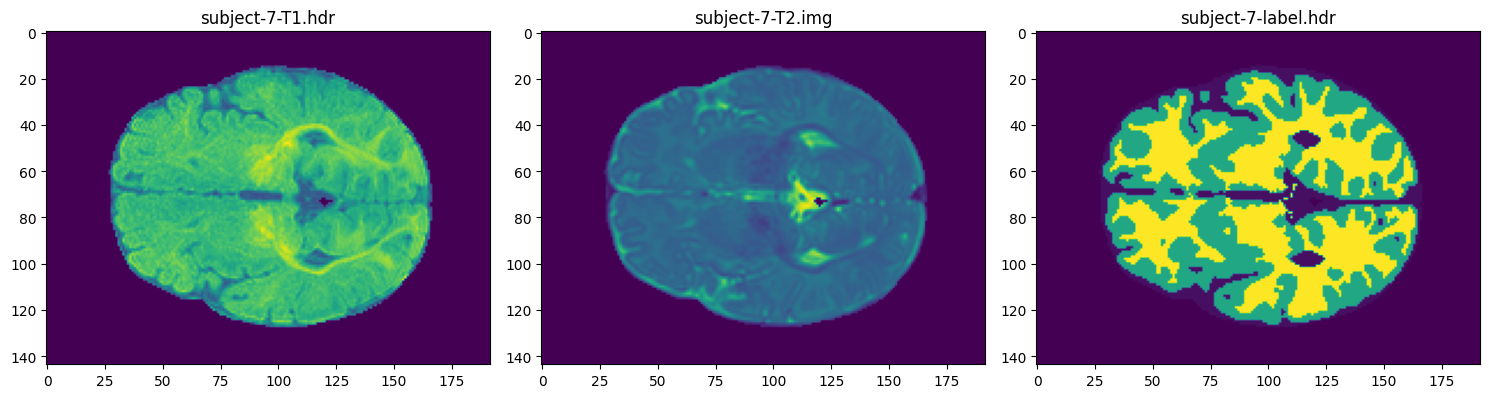

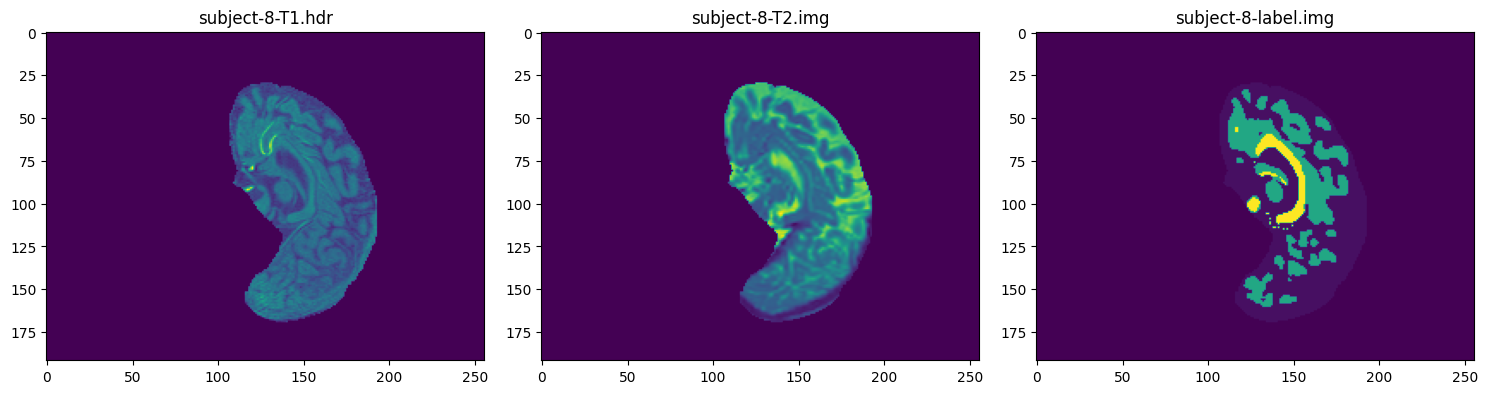

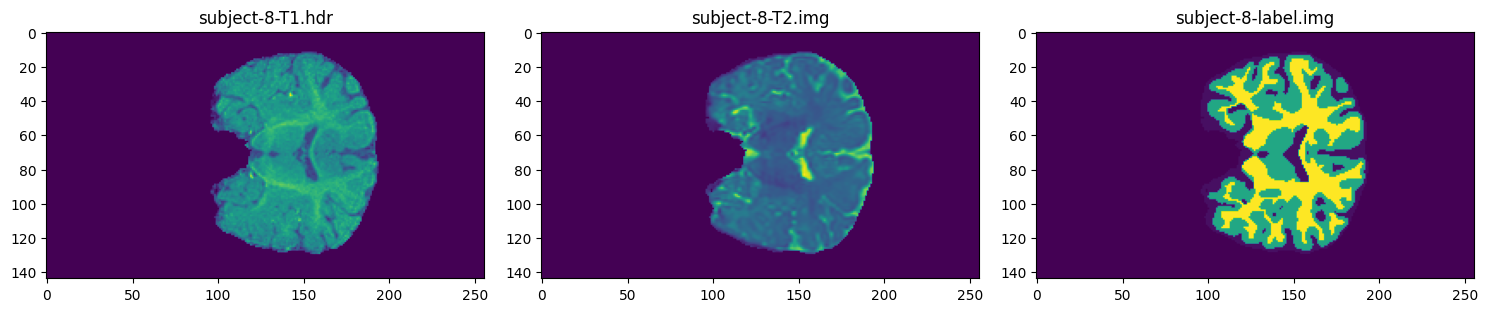

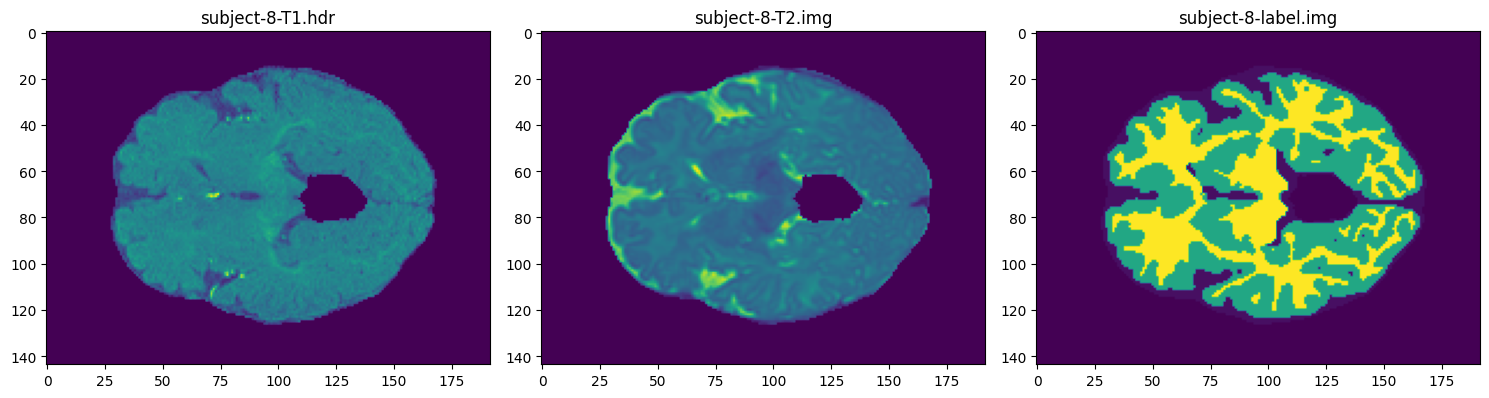

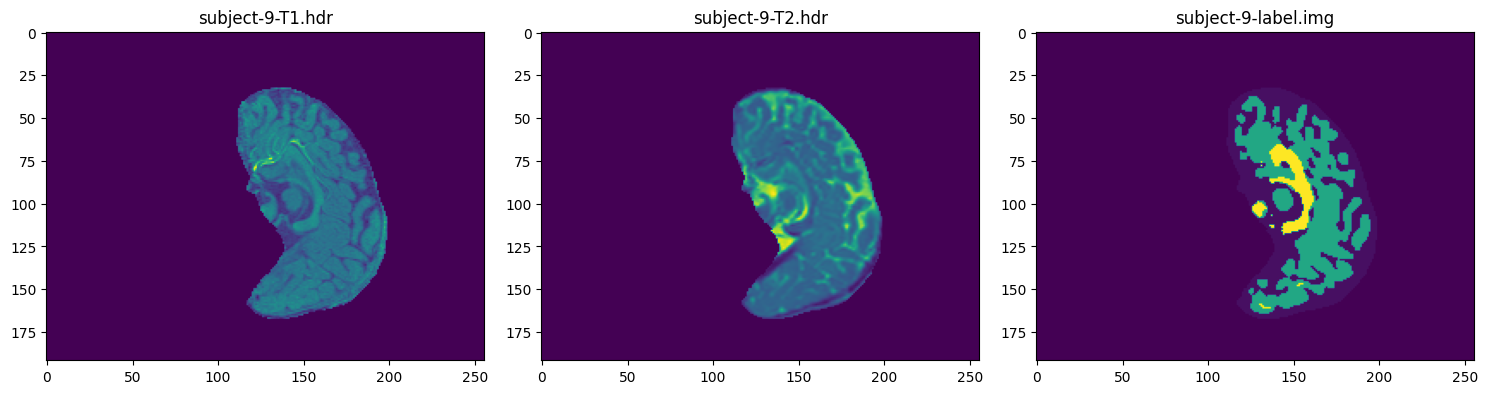

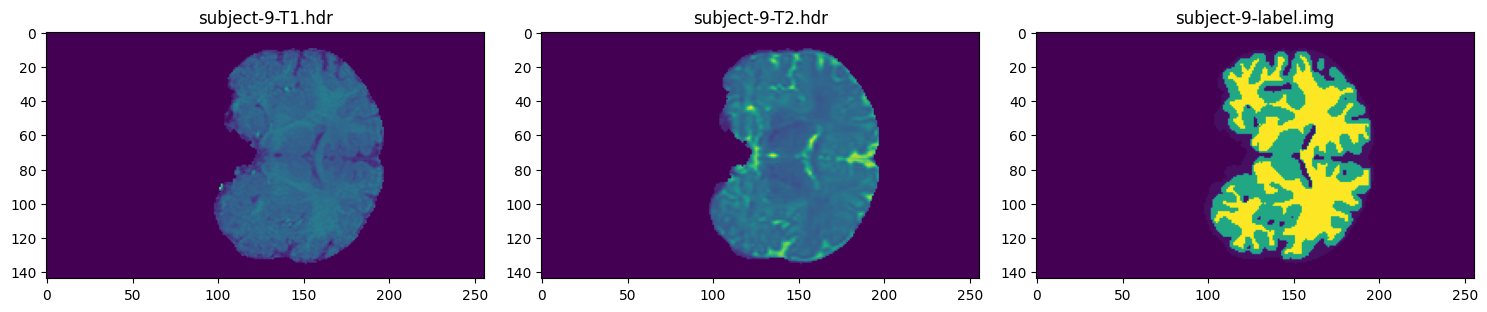

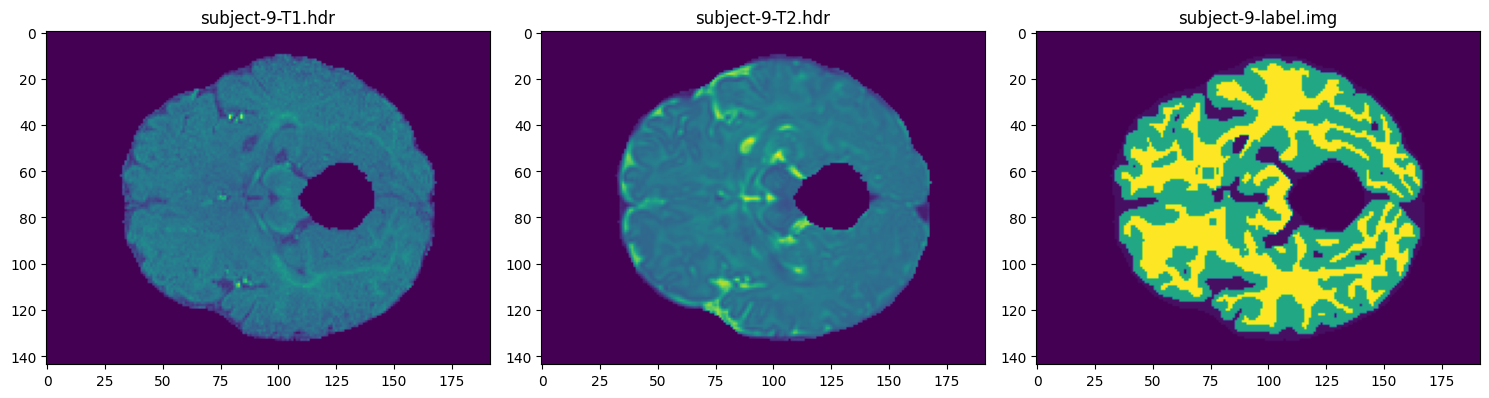

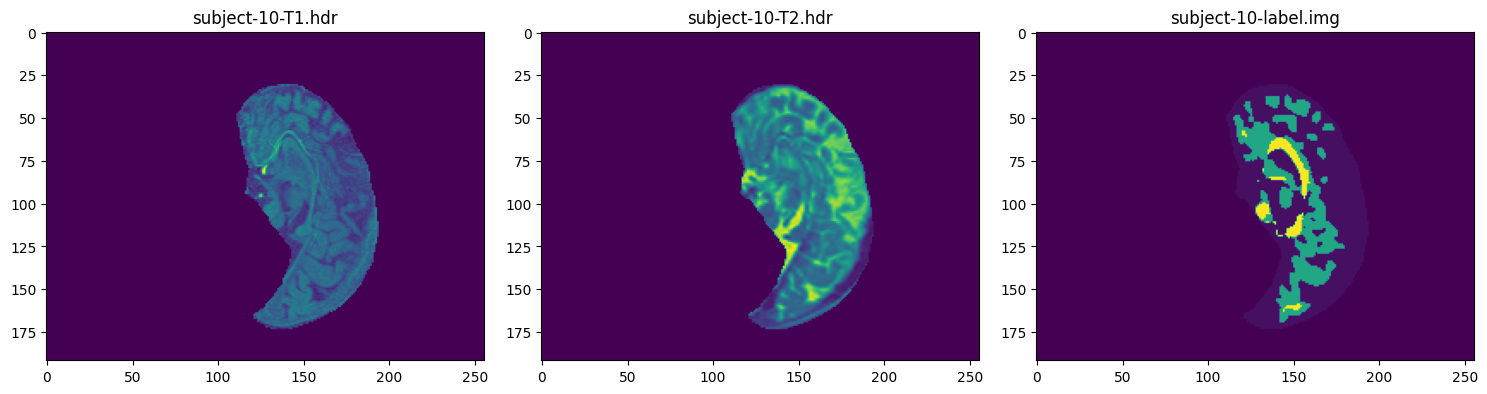

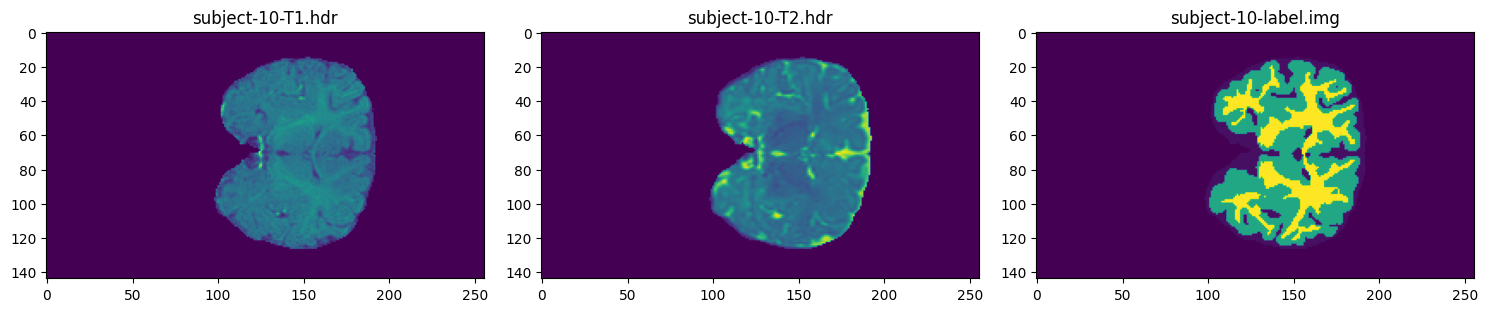

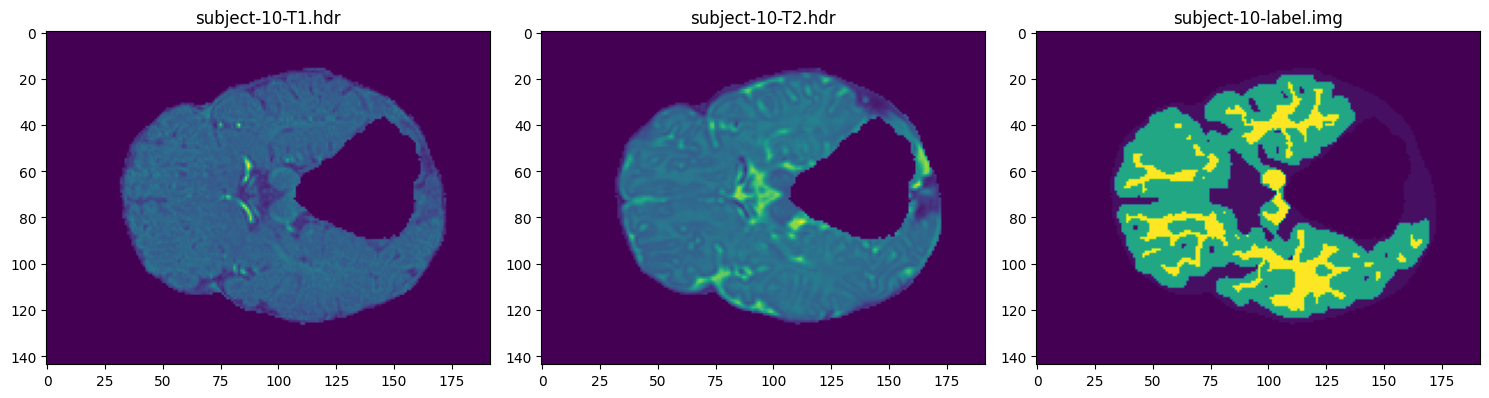

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

def load_img_subject(subject_id):
    img_arr_T1 = []
    img_arr_T2 = []
    img_arr_label = []
    for i in os.listdir('images/'):
        if i.startswith('subject-'+subject_id+'-'):
            img = nib.load('images/'+i)
            data = img.get_fdata()
            if 'T1' in i:
                img_arr_T1.append((data, i))
            elif 'T2' in i:
                img_arr_T2.append((data, i))
            else:
                img_arr_label.append((data, i))
    return img_arr_T1, img_arr_T2, img_arr_label


def display_images(images, dimention):
    img_arr_T1 = images[0]
    img_arr_T2 = images[1]
    img_arr_label = images[2]
    for i in range(0, len(img_arr_T1), 2):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        if(dimention == 1):
            ax[0].imshow(img_arr_T1[i][0][img_arr_T1[i][0].shape[0]//2,:,:])
            ax[1].imshow(img_arr_T2[i][0][img_arr_T2[i][0].shape[0]//2,:,:])
            ax[2].imshow(img_arr_label[i][0][img_arr_label[i][0].shape[0]//2,:,:])
        elif(dimention == 2):
            ax[0].imshow(img_arr_T1[i][0][:,img_arr_T1[i][0].shape[1]//2,:])
            ax[1].imshow(img_arr_T2[i][0][:,img_arr_T2[i][0].shape[1]//2,:])
            ax[2].imshow(img_arr_label[i][0][:,img_arr_label[i][0].shape[1]//2,:])
        elif (dimention == 3):
            ax[0].imshow(img_arr_T1[i][0][:,:,img_arr_T1[i][0].shape[2]//2])
            ax[1].imshow(img_arr_T2[i][0][:,:,img_arr_T2[i][0].shape[2]//2])
            ax[2].imshow(img_arr_label[i][0][:,:,img_arr_label[i][0].shape[2]//2])
        else:
            print("Invalid dimention")
            return

        ax[0].set_title(img_arr_T1[i][1])
        ax[1].set_title(img_arr_T2[i][1])
        ax[2].set_title(img_arr_label[i][1])
        plt.tight_layout()
        plt.show()

for i in range(1, 11):
    display_images(load_img_subject(str(i)), 1)
    display_images(load_img_subject(str(i)), 2)
    display_images(load_img_subject(str(i)), 3)

Dans cette partie, j'importe les bibliothèques nécessaires à notre tâche.

- nibabel est une bibliothèque Python qui permet de lire et d'écrire des données dans le format NIfTI.
- numpy est utilisé pour travailler avec des tableaux et des matrices multidimensionnels.
- matplotlib.pyplot est utilisé pour afficher les images.
- os est utilisé pour effectuer des opérations liées au système d'exploitation, comme lister les fichiers dans un répertoire.

Ce sont des importations standard pour travailler avec des données d'imagerie médicale et les afficher.

Ensuite la fonction load_img() charge les images de trois types différents (T1, T2, et label) à partir du répertoire 'images/'. Elle parcourt et charge tous les fichiers dans ce répertoire, puis extrait les données et les ajoute à la liste correspondante en fonction du type de l'image. Les données sont stockées sous forme de tuples avec le tableau de données lui-même et le nom du fichier. Enfin, elle retourne trois listes contenant les images de chaque type.

Ce code est utile pour charger un ensemble d'images à partir d'un répertoire spécifique.

On a aussi une fonction d'affichage des images. Cela m'a permis de bien visualiser ce que l'on traitait, et de me debugger parfois.

Ici j'ai affiché les coupes du milieu de chaque dimentions pour tous les patients.

In [3]:
def normalize_image(img):
    img[img < 0] = 0
    return (img - np.mean(img)) / (5 * np.std(img))

def load_norm_img_subject(subject_id):
    for i in os.listdir('images/'):
        if i.startswith('subject-'+subject_id+'-') and i.endswith('.hdr'):
            img = nib.load('images/'+i)
            data = img.get_fdata()
            data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2]))
            if 'T1' in i:
                n = normalize_image(data)
                img_arr_T1 = n
            elif 'T2' in i:
                n = normalize_image(data)
                img_arr_T2 = n
            else:
                img_arr_label = data
    return img_arr_T1, img_arr_T2, img_arr_label

def extract_z(pt_train):
    nbcoupes = 0
    for subject_id in pt_train:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        for z in range(img_arr_label.shape[2]):  # La coupe z de l'image T1
            if np.sum(np.where(img_arr_label[:, :, z] > 0, 1, 0)) > 100:
                nbcoupes += 1

    X_train = np.zeros((nbcoupes, normalized_T1.shape[0], normalized_T1.shape[1], 2))
    Y_train = np.zeros((nbcoupes, normalized_T1.shape[0], normalized_T1.shape[1]))

    # On remplit X_train et Y_train
    ind = 0
    for subject_id in pt_train:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        for z in range(img_arr_label.shape[2]):  # La coupe z de l'image T1
            if np.sum(np.where(img_arr_label[:, :, z] > 0, 1, 0)) > 100:
                X_train[ind, :, :, 0] = normalized_T1[:, :, z]
                X_train[ind, :, :, 1] = normalized_T2[:, :, z]
                Y_train[ind, :, :] = np.where((img_arr_label[:, :, z]) > 0, 1, 0)
                ind += 1

    return X_train, Y_train

patients_train = ['1', '2', '3', '4', '5', '6']
patients_val = [ '7', '8']
patients_tests = ['9', '10']
X_Train, Y_Train = extract_z(patients_train)
print(np.unique(Y_Train))
print(X_Train.shape)
X_val, Y_val = extract_z(patients_val)
print(np.unique(Y_val))

[0. 1.]
(599, 144, 192, 2)
[0. 1.]


**Fonction normalize_image**

La fonction normalize_image prend une image en entrée et effectue une normalisation. Elle remplace d'abord toutes les valeurs négatives par zéro. Ensuite, elle soustrait la moyenne de l'image et divise par cinq fois l'écart type de l'image. Cela permet de centrer les valeurs des pixels autour de zéro avec une dispersion contrôlée, ce qui peut améliorer la performance des modèles d'apprentissage automatique.

**Fonction load_norm_img_subject**

La fonction load_norm_img_subject charge et normalise les images pour un sujet spécifique, identifié par subject_id. Pour chaque fichier dans le répertoire 'images/' qui correspond à l'identifiant du sujet et se termine par '.hdr', elle charge les données d'image, les redimensionne et les normalise si nécessaire. Les images T1 et T2 sont normalisées en utilisant normalize_image, tandis que les labels ne le sont pas. La fonction retourne les images T1, T2 et les labels sous forme de tableaux normalisés.

**Fonction extract_z**

La fonction extract_z extrait des coupes transversales pertinentes des images des sujets d'entraînement. Elle prend en entrée une liste d'identifiants de sujets (pt_train) et procède en deux étapes principales :

Comptage des coupes pertinentes : Pour chaque sujet, elle charge les images normalisées (T1, T2, et labels). Ensuite, pour chaque coupe z des images, elle vérifie si le nombre de pixels non nuls dans le label est supérieur à 100. Si c'est le cas, cette coupe est considérée comme pertinente et le compteur nbcoupes est incrémenté.

Création et remplissage des tableaux X_train et Y_train : Elle initialise des tableaux vides pour stocker les données de formation. Ensuite, elle remplit ces tableaux avec les coupes pertinentes. Pour chaque coupe z considérée comme pertinente, elle ajoute les coupes T1 et T2 à X_train et les labels correspondants à Y_train.

Finalement, la fonction retourne X_train et Y_train, contenant les images normalisées et les labels sous forme de coupes transversales.

**Variables patients_train, patients_val, patients_tests**

Ces variables définissent les identifiants des patients pour différentes phases du processus d'apprentissage : formation, validation et test. patients_train contient les identifiants des patients pour l'ensemble de formation, patients_val pour l'ensemble de validation, et patients_tests pour l'ensemble de test.
La division est faite en 60/20/20 afin d'avoir un set d'entrainement consequent, tout en conservant suffisamment de données de validation et de test. Cette répartition s'est avérée la meilleure.

In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet(input_size=(144, 192, 2))
model3D = unet(input_size=(144, 192, 3))
model.fit(X_Train, Y_Train, batch_size=10, epochs=100, validation_data=(X_val, Y_val))

Epoch 1/100
60/60 [==============================] - 21s 86ms/step - loss: 0.5115 - accuracy: 0.8207 - val_loss: 0.2760 - val_accuracy: 0.9562
Epoch 2/100
60/60 [==============================] - 2s 37ms/step - loss: 0.1035 - accuracy: 0.9700 - val_loss: 0.0740 - val_accuracy: 0.9726
Epoch 3/100
60/60 [==============================] - 2s 36ms/step - loss: 0.0334 - accuracy: 0.9874 - val_loss: 0.0460 - val_accuracy: 0.9830
Epoch 4/100
60/60 [==============================] - 2s 41ms/step - loss: 0.0234 - accuracy: 0.9911 - val_loss: 0.0383 - val_accuracy: 0.9857
Epoch 5/100
60/60 [==============================] - 2s 37ms/step - loss: 0.0191 - accuracy: 0.9927 - val_loss: 0.0308 - val_accuracy: 0.9884
Epoch 6/100
60/60 [==============================] - 2s 37ms/step - loss: 0.0158 - accuracy: 0.9940 - val_loss: 0.0214 - val_accuracy: 0.9919
Epoch 7/100
60/60 [==============================] - 2s 37ms/step - loss: 0.0139 - accuracy: 0.9947 - val_loss: 0.0173 - val_accuracy: 0.9936
Epoch

La fonction unet définit l'architecture du modèle U-Net. Le U-Net est un type de réseau de neurones convolutif (CNN) couramment utilisé pour la segmentation d'images.
On utilise ici un modèle U-Net pour sa capacité à réaliser une segmentation précise des images médicales. Grâce à son architecture, il est capable de capturer des détails fins tout en intégrant des informations contextuelles importantes. C'est donc un choix optimal pour les tâches de segmentation où il est crucial de classifier chaque pixel avec une haute précision.

In [5]:
def waterfall_predict(patients):
    dice = 0
    predict = []
    for subject_id in patients:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        XTEST = np.zeros((1, normalized_T1.shape[0], normalized_T1.shape[1], 2))
        YTEST = np.zeros((img_arr_label.shape[0], normalized_T1.shape[1], normalized_T1.shape[2]))
        final = np.zeros((normalized_T1.shape[0], normalized_T1.shape[1], normalized_T1.shape[2]))
        for z in range(img_arr_label.shape[2]):
            XTEST[0, :, :, 0] = normalized_T1[:, :, z]
            XTEST[0, :, :, 1] = normalized_T2[:, :, z]
            PREDICTION = model.predict(XTEST, verbose=0)
            PREDICTION = np.reshape(PREDICTION, (PREDICTION.shape[1], PREDICTION.shape[2]))
            final[:, :, z] = np.where(PREDICTION > 0.5, 1, 0)
            YTEST[:, :, z] = np.where((img_arr_label[:, :, z]) > 0, 1, 0)
        dice += (np.sum(final * YTEST) * 2.0) / (np.sum(final) + np.sum(YTEST))
        predict.append(final)
    print(f"Moyenne premier dice : {dice/len(patients)}")
    return predict
first_predictions = waterfall_predict(patients_tests)

Moyenne premier dice : 0.9998775761649792


La fonction waterfall_predict est utilisée pour effectuer des prédictions sur un ensemble de patients en utilisant un modèle de segmentation d'images, et pour évaluer la performance de ce modèle en calculant un score de similarité appelé le coefficient de Dice.
Le coefficient de Dice est une mesure de similarité utilisée pour évaluer la performance des modèles de segmentation. Il compare la prévision du modèle avec les données réelles et est particulièrement utile dans les tâches médicales où une segmentation précise est cruciale.
Les predictions sont stockées dans la variable first_predictions.

In [6]:
def extract_z_3D(pt_train):
    nbcoupes = 0
    for subject_id in pt_train:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        for z in range(img_arr_label.shape[2]):  # La coupe z de l'image T1
            if np.sum(np.where(img_arr_label[:, :, z] > 0, 1, 0)) > 100:
                nbcoupes += 1

    X_train = np.zeros((nbcoupes, normalized_T1.shape[0], normalized_T1.shape[1], 3))
    Y_train = np.zeros((nbcoupes, normalized_T1.shape[0], normalized_T1.shape[1]))

    # On remplit X_train et Y_train
    ind = 0
    index = 0
    predict = waterfall_predict(pt_train)
    for subject_id in pt_train:
        prediction = predict[index]
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        for z in range(img_arr_label.shape[2]):  # La coupe z de l'image T1
            if np.sum(np.where(img_arr_label[:, :, z] > 0, 1, 0)) > 100:
                X_train[ind, :, :, 0] = normalized_T1[:, :, z]
                X_train[ind, :, :, 1] = normalized_T2[:, :, z]
                X_train[ind, :, :, 2] = prediction[:, :, z]
                Y_train[ind, :, :] = np.where((img_arr_label[:, :, z]) > 10, 1, 0)
                ind += 1
        index += 1

    return X_train, Y_train

X_Train, Y_Train = extract_z_3D(patients_train)
X_val, Y_val = extract_z_3D(patients_val)
model3D = unet(input_size=(144, 192, 3))
model3D.fit(X_Train, Y_Train, batch_size=10, epochs=100, validation_data=(X_val, Y_val))

def second_waterfall_predict(patients):
    dice = 0
    predict = []
    index = 0
    first_predictions = waterfall_predict(patients)
    for subject_id in patients:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        pred = first_predictions[index]
        XTEST = np.zeros((1, normalized_T1.shape[0], normalized_T1.shape[1], 3))
        YTEST = np.zeros((img_arr_label.shape[0], normalized_T1.shape[1], normalized_T1.shape[2]))
        final = np.zeros((normalized_T1.shape[0], normalized_T1.shape[1], normalized_T1.shape[2]))
        for z in range(img_arr_label.shape[2]):
            XTEST[0, :, :, 0] = normalized_T1[:, :, z]
            XTEST[0, :, :, 1] = normalized_T2[:, :, z]
            XTEST[0, :, :, 2] = pred[:, :, z]
            PREDICTION = model3D.predict(XTEST, verbose=0)
            PREDICTION = np.reshape(PREDICTION, (PREDICTION.shape[1], PREDICTION.shape[2]))
            final[:, :, z] = np.where(PREDICTION > 0.5, 1, 0)
            YTEST[:, :, z] = np.where((img_arr_label[:, :, z]) > 10, 1, 0)
        dice += (np.sum(final * YTEST) * 2.0) / (np.sum(final) + np.sum(YTEST))
        predict.append(final)
        index += 1
    print(f"Moyenne deuxième dice : {dice/len(patients)}")
    return predict

second_predictions = second_waterfall_predict(patients_tests)

Moyenne premier dice : 0.9999085442021244
Moyenne premier dice : 0.999879364636328
Epoch 1/100
60/60 [==============================] - 10s 50ms/step - loss: 0.6498 - accuracy: 0.7641 - val_loss: 0.5036 - val_accuracy: 0.7763
Epoch 2/100
60/60 [==============================] - 2s 38ms/step - loss: 0.3717 - accuracy: 0.7742 - val_loss: 0.3045 - val_accuracy: 0.7764
Epoch 3/100
60/60 [==============================] - 2s 38ms/step - loss: 0.2342 - accuracy: 0.7741 - val_loss: 0.2320 - val_accuracy: 0.7765
Epoch 4/100
60/60 [==============================] - 2s 38ms/step - loss: 0.2112 - accuracy: 0.7742 - val_loss: 0.2185 - val_accuracy: 0.7765
Epoch 5/100
60/60 [==============================] - 2s 41ms/step - loss: 0.2061 - accuracy: 0.8683 - val_loss: 0.2098 - val_accuracy: 0.9443
Epoch 6/100
60/60 [==============================] - 2s 38ms/step - loss: 0.1998 - accuracy: 0.9474 - val_loss: 0.2007 - val_accuracy: 0.9544
Epoch 7/100
60/60 [==============================] - 2s 38ms/ste

La fonction extract_z_3D a le meme foncitonnement que extract_z, mais en 3 dimentions.
Elle utilise les prédictions d'une étape précédente pour ajouter un troisième canal aux données d'entrée, ce qui permet au modèle 3D d'apprendre non seulement à partir des images T1 et T2, mais aussi des résultats des prédictions initiales.
La fonction second_waterfall_predict utilise les prédictions de la première étape pour prédire les masques des images de test.
Les résultats sont stockés dans second_predictions, qui contient les masques prédits pour chaque patient de l'ensemble de test.
Elle fonctionne de la même manière que waterfall_predict, mais en utilisant les prédictions de la première étape pour améliorer la segmentation.

In [7]:
def extract_z_4D(pt_train):
    nbcoupes = 0
    for subject_id in pt_train:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        for z in range(img_arr_label.shape[2]):  # La coupe z de l'image T1
            if np.sum(np.where(img_arr_label[:, :, z] > 0, 1, 0)) > 100:
                nbcoupes += 1

    X_train = np.zeros((nbcoupes, normalized_T1.shape[0], normalized_T1.shape[1], 4))
    Y_train = np.zeros((nbcoupes, normalized_T1.shape[0], normalized_T1.shape[1]))

    # On remplit X_train et Y_train

    ind = 0
    index = 0
    first_pred = waterfall_predict(pt_train)
    second_pred = second_waterfall_predict(pt_train)
    for subject_id in pt_train:
        first_prediction = first_pred[index]
        second_prediction = second_pred[index]
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        for z in range(img_arr_label.shape[2]):  # La coupe z de l'image T1
            if np.sum(np.where(img_arr_label[:, :, z] > 0, 1, 0)) > 100:
                X_train[ind, :, :, 0] = normalized_T1[:, :, z]
                X_train[ind, :, :, 1] = normalized_T2[:, :, z]
                X_train[ind, :, :, 2] = first_prediction[:, :, z]
                X_train[ind, :, :, 3] = second_prediction[:, :, z]
                Y_train[ind, :, :] = np.where((img_arr_label[:, :, z]) > 150, 1, 0)
                ind += 1
        index += 1

    return X_train, Y_train

X_Train, Y_Train = extract_z_4D(patients_train)
X_val, Y_val = extract_z_4D(patients_val)
model4D = unet(input_size=(144, 192, 4))
model4D.fit(X_Train, Y_Train, batch_size=10, epochs=100, validation_data=(X_val, Y_val))

def third_waterfall_predict(patients):
    dice = 0
    index = 0
    predict = []
    for subject_id in patients:
        normalized_T1, normalized_T2, img_arr_label = load_norm_img_subject(subject_id)
        first_pred = first_predictions[index]
        second_pred = second_predictions[index]
        XTEST = np.zeros((1, normalized_T1.shape[0], normalized_T1.shape[1], 4))
        YTEST = np.zeros((img_arr_label.shape[0], normalized_T1.shape[1], normalized_T1.shape[2]))
        final = np.zeros((normalized_T1.shape[0], normalized_T1.shape[1], normalized_T1.shape[2]))
        for z in range(img_arr_label.shape[2]):
            XTEST[0, :, :, 0] = normalized_T1[:, :, z]
            XTEST[0, :, :, 1] = normalized_T2[:, :, z]
            XTEST[0, :, :, 2] = first_pred[:, :, z]
            XTEST[0, :, :, 3] = second_pred[:, :, z]
            PREDICTION = model4D.predict(XTEST, verbose=0)
            PREDICTION = np.reshape(PREDICTION, (PREDICTION.shape[1], PREDICTION.shape[2]))
            final[:, :, z] = np.where(PREDICTION > 0.5, 1, 0)
            YTEST[:, :, z] = np.where((img_arr_label[:, :, z]) > 150, 1, 0)
        dice += (np.sum(final * YTEST) * 2.0) / (np.sum(final) + np.sum(YTEST))
        predict.append(final)
        index += 1
    print(f"Moyenne troisième dice : {dice/len(patients)}")
    return predict

third_prediction = third_waterfall_predict(patients_tests)

Moyenne premier dice : 0.9999085442021244
Moyenne premier dice : 0.9999085442021244
Moyenne deuxième dice : 0.9095941973310815
Moyenne premier dice : 0.999879364636328
Moyenne premier dice : 0.999879364636328
Moyenne deuxième dice : 0.9100533009362501
Epoch 1/100
60/60 [==============================] - 10s 53ms/step - loss: 0.4792 - accuracy: 0.9057 - val_loss: 0.2530 - val_accuracy: 0.9122
Epoch 2/100
60/60 [==============================] - 2s 39ms/step - loss: 0.1685 - accuracy: 0.9101 - val_loss: 0.1972 - val_accuracy: 0.9122
Epoch 3/100
60/60 [==============================] - 2s 38ms/step - loss: 0.1569 - accuracy: 0.9101 - val_loss: 0.1898 - val_accuracy: 0.9122
Epoch 4/100
60/60 [==============================] - 2s 41ms/step - loss: 0.1523 - accuracy: 0.9101 - val_loss: 0.1812 - val_accuracy: 0.9122
Epoch 5/100
60/60 [==============================] - 2s 41ms/step - loss: 0.1487 - accuracy: 0.9101 - val_loss: 0.1747 - val_accuracy: 0.9122
Epoch 6/100
60/60 [==================

Comme pour les précédents, les fonctions ici fonctionnent a peu près comme les précédentes.
La fonction extract_z_4D est utilisée pour préparer les données d'entraînement pour un modèle de segmentation 4D, en ajoutant une quatrième dimension basée sur les prédictions des modèles précédents. Inclure les prédictions des modèles précédents comme canal d'entrée supplémentaire permet au modèle 4D d'apprendre des informations contextuelles supplémentaires et d'améliorer la segmentation.

Pour third_waterfall_predict, elle fonctionne de la même manière que les fonctions précédentes, mais en utilisant les prédictions des deux premières étapes pour améliorer la segmentation. Elle utilise les prédictions des deux premières étapes pour prédire les masques des images de test, et stocke les résultats dans third_predictions. Comme les autres, le Dice score est calculé pour évaluer la performance du modèle.

In [8]:
prediction_finale = 10 * first_predictions + 140 * second_predictions + 100 * third_prediction

#print("Valeurs uniques dans la prédiction finale :", np.unique(prediction_finale))
#pas assez de memoire pour compiler

Ici on calcule une prédiction finale en regroupant les predictions binaires des 3 réseaux

### CONCLUSION

Ce TP était très intéressant, et m'a permis de découvrir un nouvel aspect de l'apprentissage profond. J'ai pu voir comment les réseaux de neurones convolutifs peuvent être utilisés pour segmenter des images médicales, et comment les modèles peuvent être améliorés en utilisant des informations contextuelles supplémentaires. J'ai pu découvrir l'importance de l'architecture d'un réseau de neurones comme un U-Net. J'ai également appris à évaluer la performance des modèles en utilisant des mesures de similarité comme le coefficient de Dice. Ce TP m'a donné un aperçu de la façon dont l'apprentissage profond peut être appliqué à des problèmes médicaux et comment il peut être utilisé pour améliorer la précision des diagnostics et des traitements.